In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn

import numbers

In [2]:
def V_step(V, F):
    """
    Computes next position given current position and forcing inputs
    V: car's current position in 6D space, (x , y, theta, s, omega, t)
    F: current forcing inputs, (phi, psi, dt)
    """
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    """
    Returns smallest angular difference in (0, pi) between two angles
    """
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def loss_fun(Y, T, F, scale=None):
    """
    Y: final state (6D: x, y, theta, s, omega, t)
    T: target (5D)
    F: list of forcings
    """
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T) * scale
    diff[2] = angle_diff(Y[2], T[2])
    target_loss = pt.dot(diff, diff)                # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(F[:,0:2]**2)                  # loss by using too much force
    return target_loss, time_loss, l2_loss

def get_forcing(V, F):
    """
    Returns true forcings from logits
    """
    limits_min = pt.tensor([-0.8, -0.8, 0.001], device=F.device)
    limits_max = pt.tensor([0.8, 0.8, 0.25], device=F.device)
    return limits_min + (limits_max - limits_min) * pt.sigmoid(F)

# Compute a path while modifing V_mat and F_mat inplace
def compute_path_autograd(V0, F_request, target):
    """
    Computes entire path given initial position and logits of forcings. Computes loss given target.
    V0: initial position
    F_logits: logits of forcing terms
    target: target position in 5D space
    """

    V_list = [V0]
    F_true = []

    for i in range(F_request.shape[0]):
        F_true.append(get_forcing(V_list[i], F_request[i]))
        V_list.append(V_step(V_list[i], F_true[i]))

    loss = loss_fun(V_list[-1], target, pt.stack(F_true))

    return V_list, loss

def to_tensor(V_mat):
    """
    Splits V_mat into position components (5D) and time component (1D)
    """
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

def to_lambda(schedule):
    if schedule is None:
        return lambda x, target_loss: 0
    if isinstance(schedule, numbers.Number):
        return lambda x, target_loss: schedule
    if callable(schedule):
        return schedule
    raise TypeError(f'Invalid schedule type: {type(schedule)}. Expected None, a number, or a function.')

In [3]:
def plot_traj(V_records, target, alphas=None, ax=None, figsize=(8,6)):
    """
    Plots trajectories of car on existing axes object or creates new one
    V_mat: list of lists (n_logs x n_segments)
           each sublist holds n_segments 5D tensors
           each 5D tensor holds position sequence of each segment for a given iteration
    target: target position in 5D space
    """
    num_records = V_records.shape[0]

    if alphas is None:
        alphas = np.ones(num_records)
        alphas[:-1] = np.linspace(0.1, 0.8, num_records-1)
    
    arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True
    
    ax.scatter(V_records[0,0,0], V_records[0,0,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
    ax.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, label='Target')
    ax.scatter(V_records[-1,-1,0], V_records[-1,-1,1], marker='o', color='dodgerblue', s=120, zorder=10, label='End')


    ax.arrow(*V_records[0,0,0:2], *arrowDir(V_records[0,0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
    ax.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
    ax.arrow(*V_records[-1,-1,0:2], *arrowDir(V_records[-1,-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=3, zorder=2)

    for i in range(num_records):
        lw = 1 if alphas[i] != 1 else 2
        ax.plot(V_records[i,:,0], V_records[i,:,1], color='dodgerblue', lw=lw, alpha=alphas[i])

    ax.set_title('Trajectory')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.axis('equal')
    ax.grid()
    ax.legend()

    return (fig, ax) if fig_exists is True else ax


def plot_forcing(F_records, ts_records, alphas=None, ax=None, figsize=(8,6)):
    """
    Plots evolution of forcing terms on existin axes object or creates a new one
    F_records: tensor of concatenated true forcings (n_records x n_steps x 3)
    ts_records tensor of times for each log (n_records x n_steps)
    """
    num_records = F_records.shape[0]

    if alphas is None:
        alphas = np.ones(num_records)
        alphas[:-1] = np.linspace(0.1, 0.8, num_records-1)
    
    fig_exists = False
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True

    for i in range(num_records-1):
        lw = 1.5 if alphas[i] != 1 else 2
        plt.plot(ts_records[i,:-1].detach().numpy(), F_records[i,:,0].detach().numpy(), color='deeppink', lw=lw, alpha=alphas[i])
        plt.plot(ts_records[i,:-1].detach().numpy(), F_records[i,:,1].detach().numpy(), color='limegreen', lw=lw, alpha=alphas[i])
    
    lw = 1 if alphas[i] != 1 else 2
    plt.plot(ts_records[-1,:-1].detach().numpy(), F_records[-1,:,0].detach().numpy(), color='deeppink', lw=lw, alpha=alphas[-1], label='Acceleration Force')
    plt.plot(ts_records[-1,:-1].detach().numpy(), F_records[-1,:,1].detach().numpy(), color='limegreen', lw=lw, alpha=alphas[-1], label='Turning Force')

    left, right = ax.get_xlim()
    ax.plot([left, right], [0.8, 0.8], '--k', lw=1.5)
    ax.plot([left, right], [-0.8, -0.8], '--k', lw=1.5)
    
    ax.legend()
    ax.set_title('Forcing Terms')
    ax.set_xlabel('Time')
    ax.set_ylabel('Force')
    ax.set_ylim([-0.85, 0.85])
    ax.grid()

    return (fig, ax) if fig_exists is True else ax

In [4]:
t0 = 0
t1 = 5.5       # designed for 5.5
dt_max = 0.25
n_steps = 2**np.ceil(np.log2((t1 - t0)/ dt_max)).astype(int)
print(f'Path has {n_steps} steps')

v0 = pt.tensor([0, 0, 0.2, 1, 1, t0], requires_grad=True)
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

F_mat = nn.Parameter(pt.zeros((n_steps, 3)))
V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

optim = pt.optim.AdamW([F_mat], lr=6e-2, weight_decay=0)


pt.autograd.set_detect_anomaly(False)

figaxs = None
iters = 1000
plot_freq = 50
num_records = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1

V_records = pt.zeros((num_records, n_steps+1, 5))
F_records = pt.zeros((num_records, n_steps, 3))
ts_records = pt.zeros((num_records, n_steps+1))

for i in range(iters):
    is_record_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
    record_idx = i // plot_freq
    
    optim.zero_grad()
    V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)


    dist = target_loss ** 0.5

    l2_coef = -1e0
    time_coef = 1e-8


    loss = target_loss + time_coef*time_loss + l2_coef*l2_loss
    loss.backward()
    optim.step()

    #with pt.no_grad():
    #    F_mat.copy_(get_forcing(pt.stack(V_mat[:-1]), F_mat))

    if i % plot_freq == plot_freq-1:
        print(f"Iteration {i+1}, Target Dist: {target_loss ** 0.5:.3f}, End Time: {time_loss:.3f}, L2: {l2_loss:.3f}")
        if i < iters-1:
            traj, ts = to_tensor(V_mat)
            V_records[record_idx,:,:] = traj
            F_records[record_idx,:,:] = get_forcing(pt.stack(V_mat[:-1]), F_mat)
            ts_records[record_idx,:] = ts

traj, ts = to_tensor(V_mat)
V_records[record_idx,:,:] = traj
F_records[record_idx,:,:] = get_forcing(pt.stack(V_mat[:-1]), F_mat)
ts_records[record_idx,:] = ts

Path has 32 steps
Iteration 50, Target Dist: 1.954, End Time: 4.852, L2: 0.271
Iteration 100, Target Dist: 0.325, End Time: 4.427, L2: 0.285
Iteration 150, Target Dist: 0.216, End Time: 4.578, L2: 0.291
Iteration 200, Target Dist: 0.194, End Time: 4.591, L2: 0.295
Iteration 250, Target Dist: 0.162, End Time: 4.590, L2: 0.298
Iteration 300, Target Dist: 0.115, End Time: 4.593, L2: 0.303
Iteration 350, Target Dist: 0.066, End Time: 4.591, L2: 0.312
Iteration 400, Target Dist: 0.034, End Time: 4.578, L2: 0.326
Iteration 450, Target Dist: 0.021, End Time: 4.554, L2: 0.343
Iteration 500, Target Dist: 0.018, End Time: 4.524, L2: 0.362
Iteration 550, Target Dist: 0.021, End Time: 4.495, L2: 0.381
Iteration 600, Target Dist: 0.024, End Time: 4.468, L2: 0.400
Iteration 650, Target Dist: 0.028, End Time: 4.444, L2: 0.417
Iteration 700, Target Dist: 0.030, End Time: 4.423, L2: 0.434
Iteration 750, Target Dist: 0.032, End Time: 4.404, L2: 0.450
Iteration 800, Target Dist: 0.033, End Time: 4.388, L

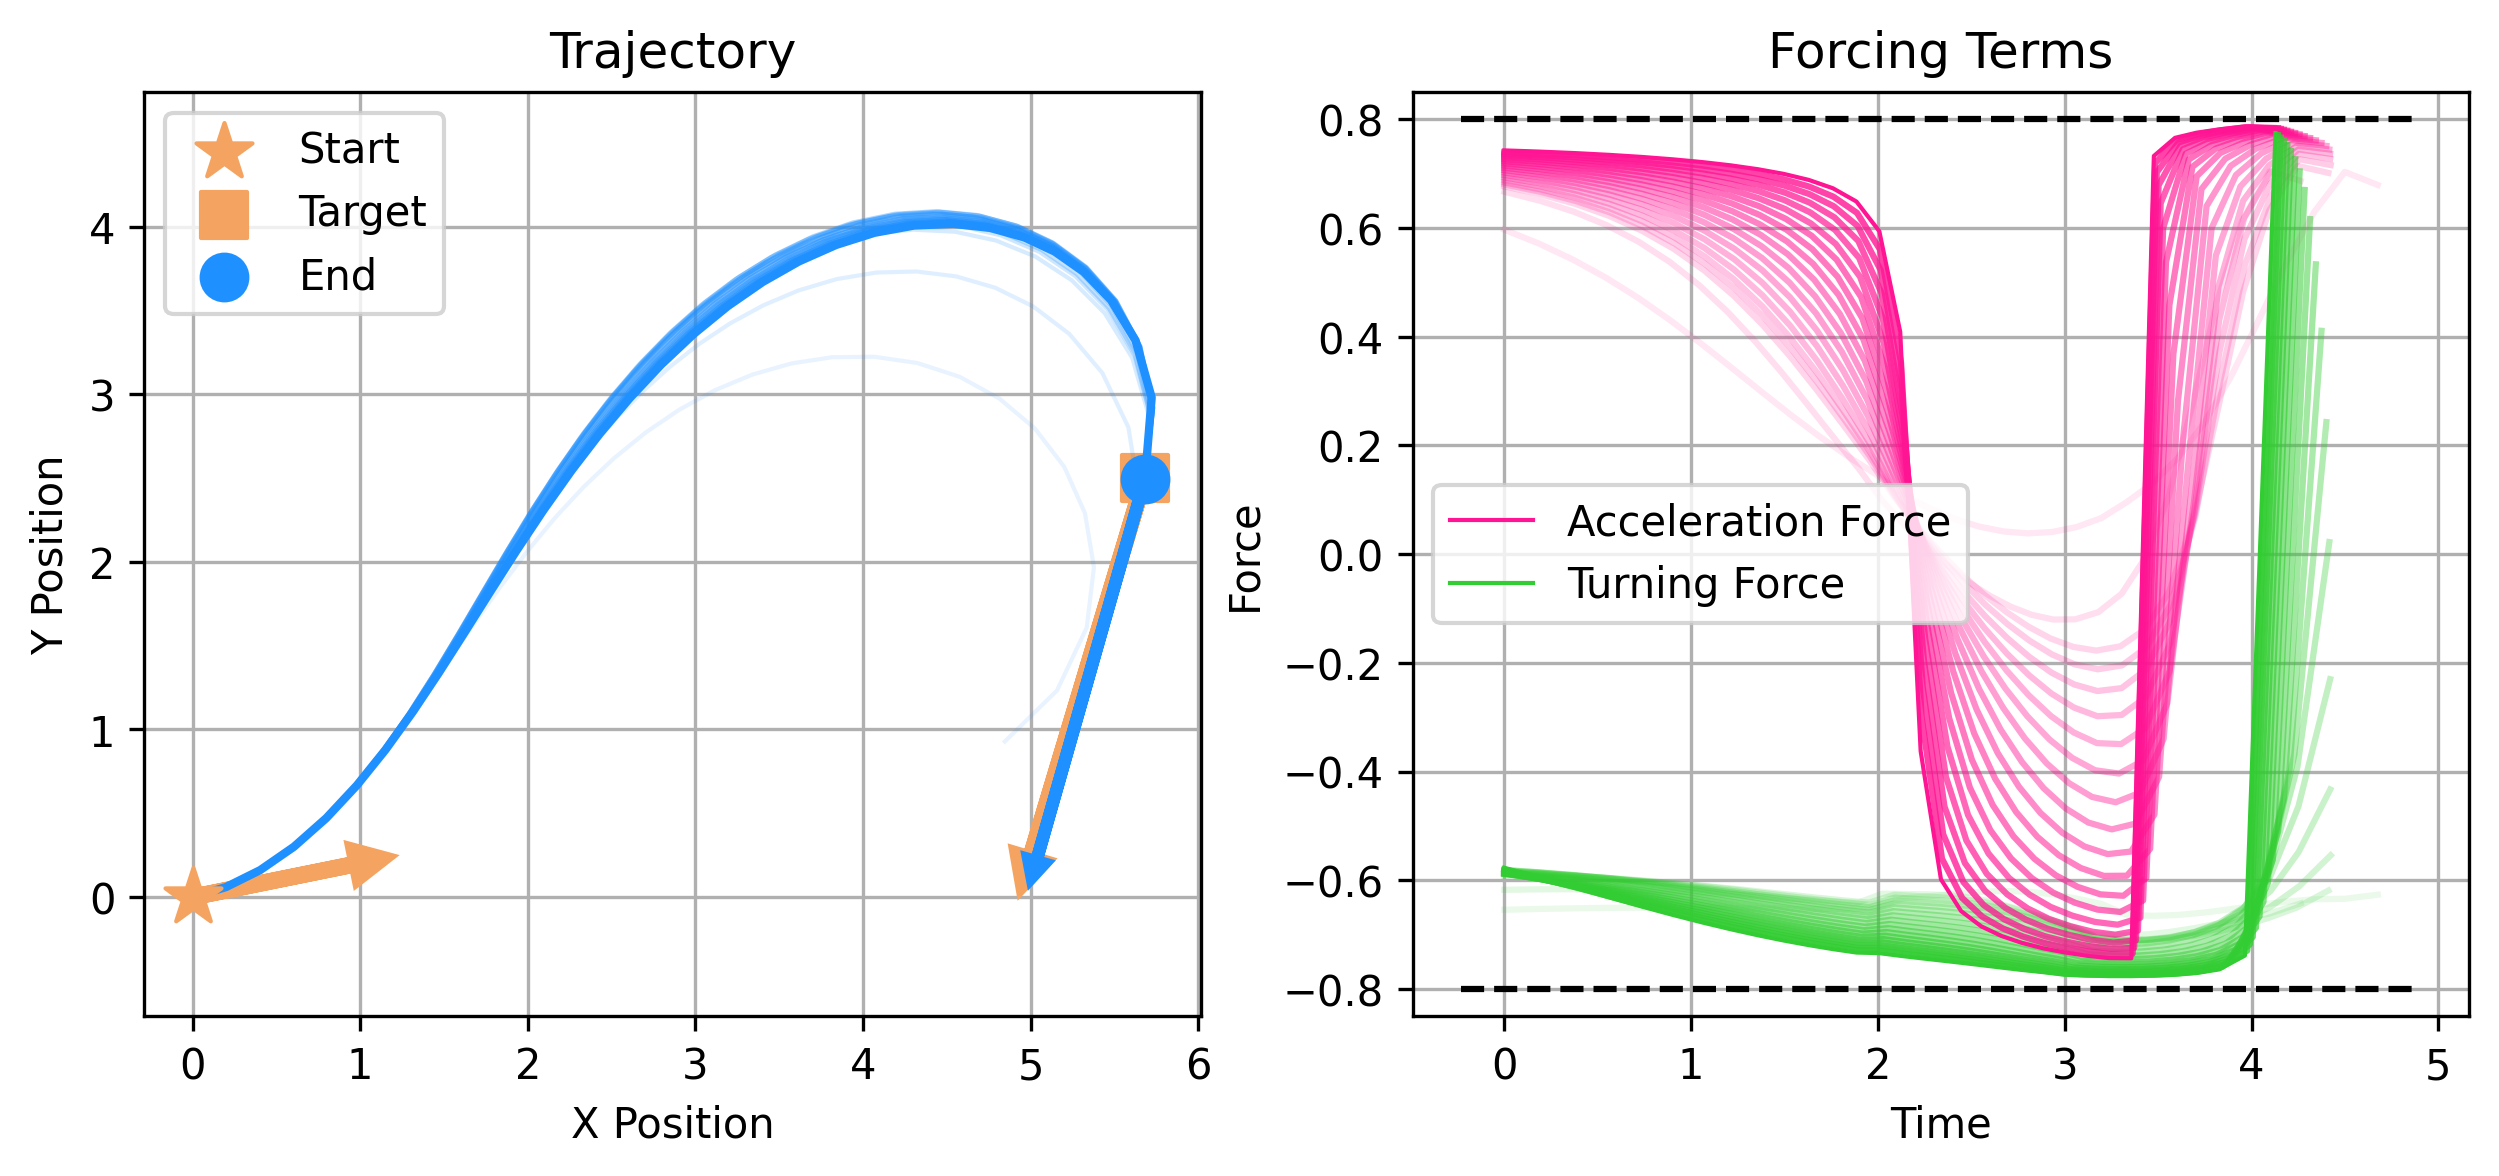

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_records, target, ax=ax1)
plot_forcing(F_records, ts_records, ax=ax2)
plt.show()

### Testing reverse loss

In [6]:
def optimizePath(v0, target, F_logits, iters=500, fine_tuning_steps=50, plot_freq=50,
        lr=9e-2, l2_rate=-1e0, time_rate=2e-8, reverse_rate=0.5, show_logs=True):
    
    """
    Iteratively performs GD to optimize forcings
    
    v0: starting tensor in 6d (v0[5]=0)
    target: ending tensor in 5d
    checkpoint_dof: num_checkpoints x 3 tensor containing learnable dfs at start of segments
    F_logits: (n_steps, 3) learnable parameter
    """
    num_records = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1
    n_steps = F_logits.shape[0]
    V_records = pt.zeros((num_records, n_steps+1, 5))
    F_true = pt.zeros((num_records, n_steps, 3))
    ts_records = pt.zeros((num_records, n_steps+1))
    loss_records = pt.zeros((num_records, 4))

    optim = pt.optim.Adam([F_logits])

    for i in range(iters):
        x = i / (iters - fine_tuning_steps)
        lr = to_lambda(lr)
        l2_rate = to_lambda(l2_rate)
        time_rate = to_lambda(time_rate)
        reverse_rate = to_lambda(reverse_rate)

        is_record_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
        record_idx = i // plot_freq
        
        optim.zero_grad()
        V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_logits, target)


        dist = target_loss ** 0.5

        l2_coef = l2_rate(x, target_loss) if i < iters-fine_tuning_steps else 0
        time_coef = time_rate(x, target_loss) if i < iters-fine_tuning_steps else 0
        reverse_coef = reverse_rate(x, target_loss) if i < iters-fine_tuning_steps else 0

        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(V_mat)[:,3]))


        loss = target_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss
        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, target_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()
        

        if is_record_step:
            print(f"Iteration {i+1}, Target Dist: {dist:.3f}, End Time: {time_loss:.3f}, L2: {l2_loss:.3f}")
            traj, ts = to_tensor(V_mat)
            V_records[record_idx,:,:] = traj
            F_records[record_idx,:,:] = get_forcing(pt.stack(V_mat[:-1]), F_logits)
            ts_records[record_idx,:] = ts
            loss_records[record_idx,:] = pt.tensor([target_loss, time_loss, l2_loss, reverse_loss])
    
    return F_logits, F_records, V_records, ts_records, loss_records

Path has 32 steps
Iteration 50, Target Dist: 1.407, End Time: 6.437, L2: 0.232
Iteration 100, Target Dist: 0.420, End Time: 7.158, L2: 0.292
Iteration 150, Target Dist: 0.256, End Time: 7.237, L2: 0.327
Iteration 200, Target Dist: 0.175, End Time: 7.303, L2: 0.355
Iteration 250, Target Dist: 0.127, End Time: 7.360, L2: 0.379
Iteration 300, Target Dist: 0.096, End Time: 7.403, L2: 0.402
Iteration 350, Target Dist: 0.075, End Time: 7.435, L2: 0.423
Iteration 400, Target Dist: 0.061, End Time: 7.459, L2: 0.443
Iteration 450, Target Dist: 0.053, End Time: 7.476, L2: 0.461
Iteration 500, Target Dist: 0.049, End Time: 7.485, L2: 0.477
Iteration 550, Target Dist: 0.047, End Time: 7.488, L2: 0.491
Iteration 600, Target Dist: 0.047, End Time: 7.486, L2: 0.505
Iteration 650, Target Dist: 0.049, End Time: 7.482, L2: 0.520
Iteration 700, Target Dist: 0.051, End Time: 7.480, L2: 0.535
Iteration 750, Target Dist: 0.049, End Time: 7.481, L2: 0.548
Iteration 800, Target Dist: 0.047, End Time: 7.487, L

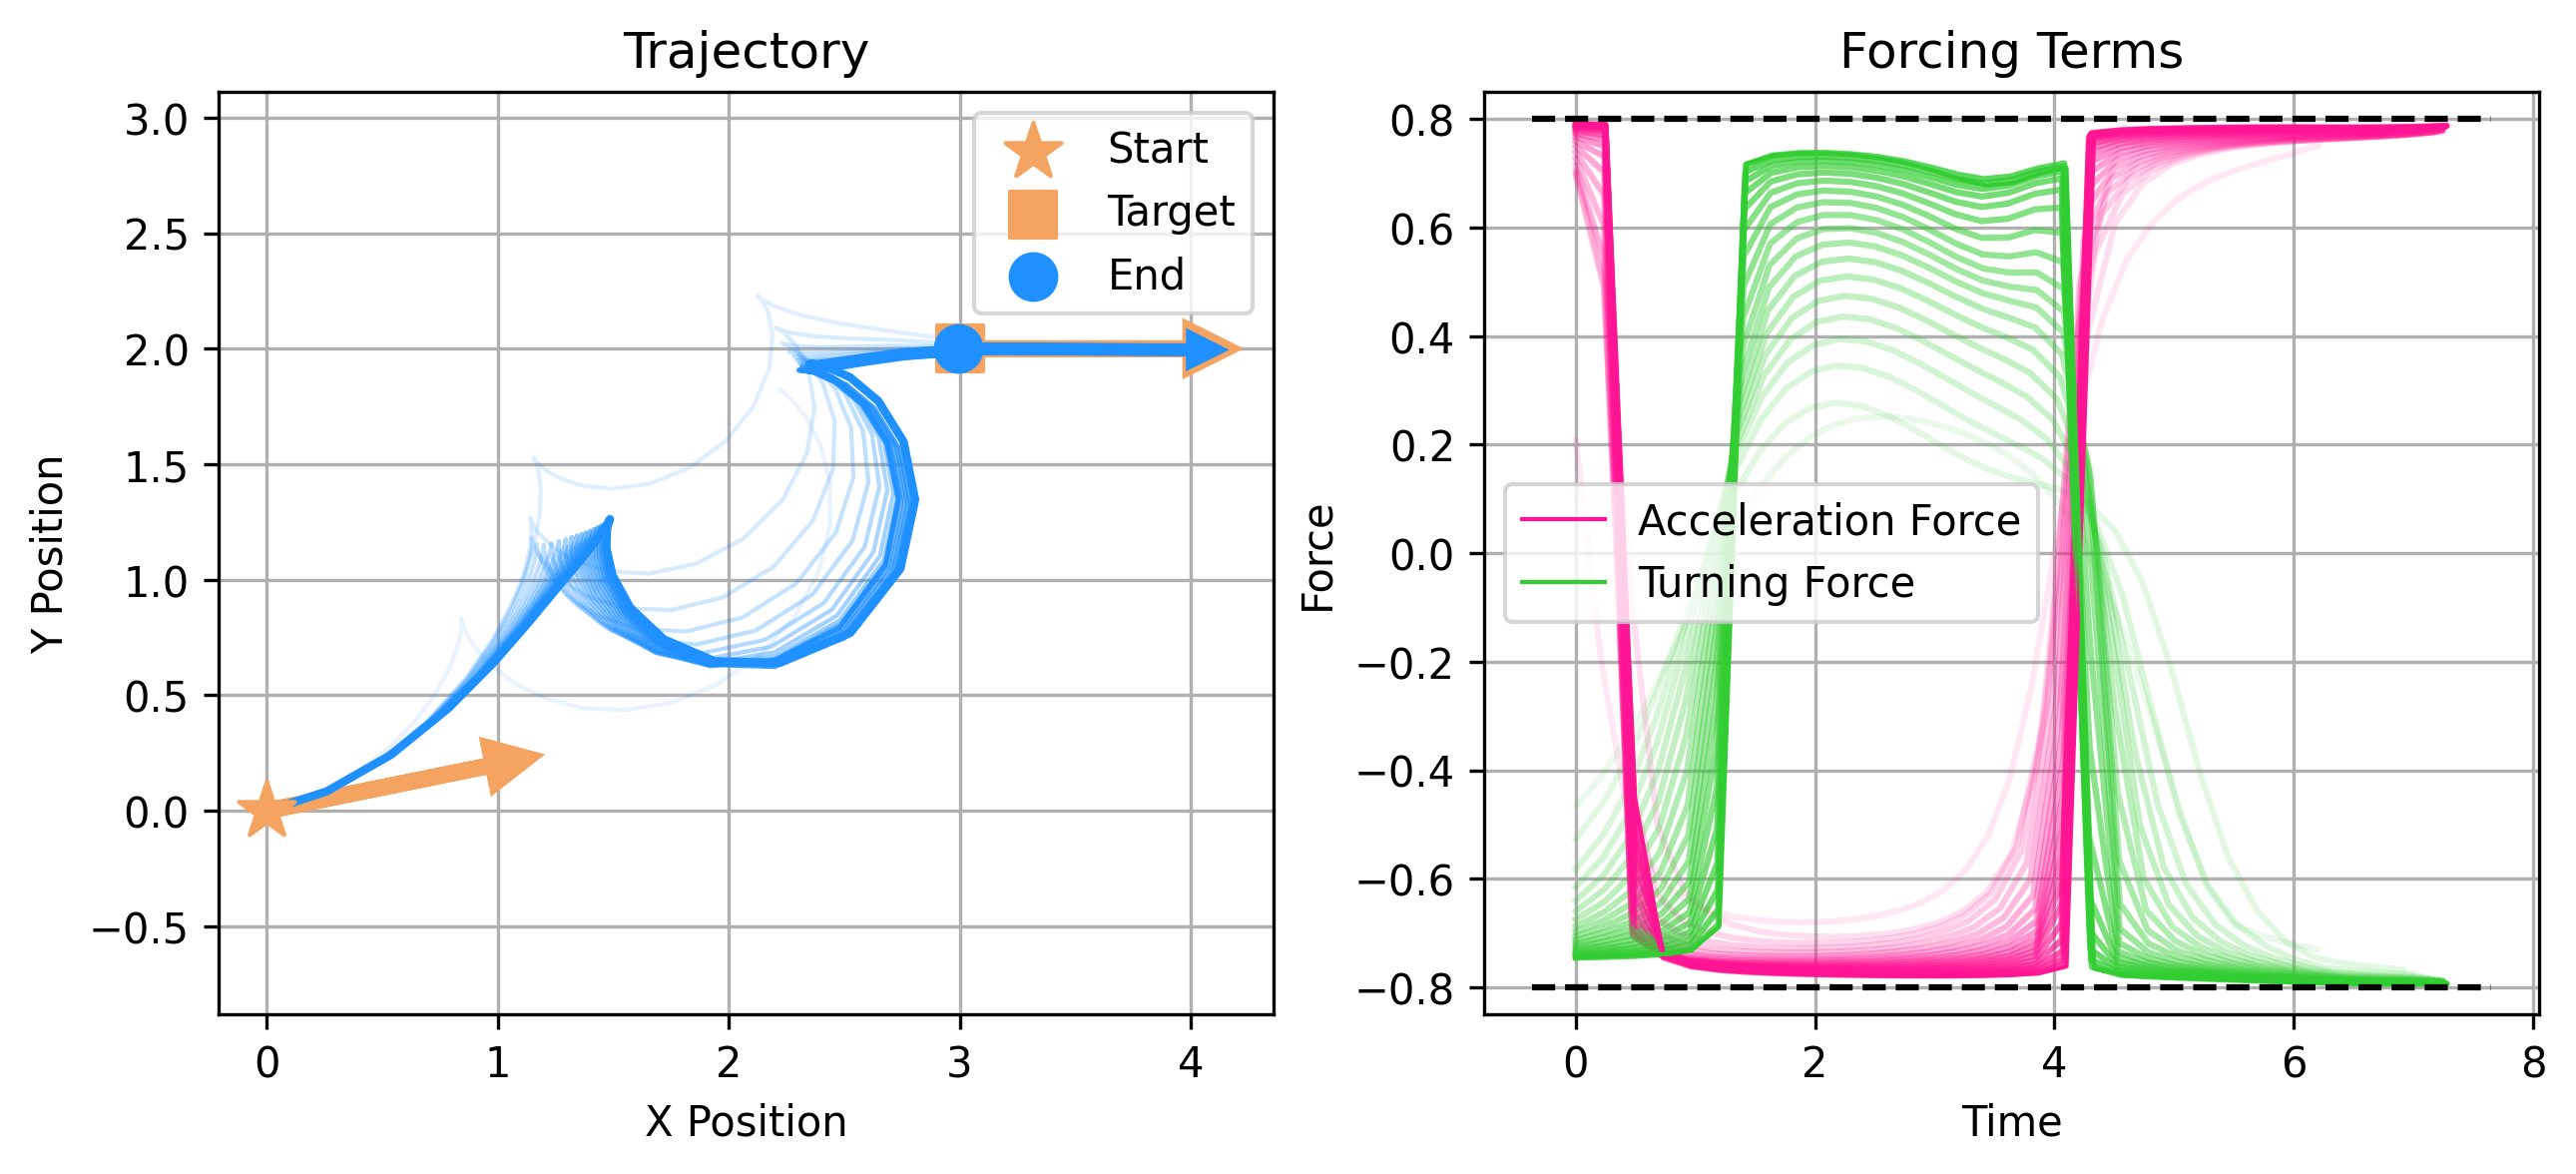

In [7]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = 32

print(f'Path has {n_steps} steps')

F_logits = nn.Parameter(pt.zeros((n_steps, 3)))

F_logits, F_true, V_mat, ts_records, loss_logs = optimizePath(v0, target, F_logits,
                                                                               reverse_rate=0,
                                                                               iters=1000)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_true, ts_records, ax=ax2)
plt.show()

<Axes: title={'center': 'Trajectory'}, xlabel='X Position', ylabel='Y Position'>

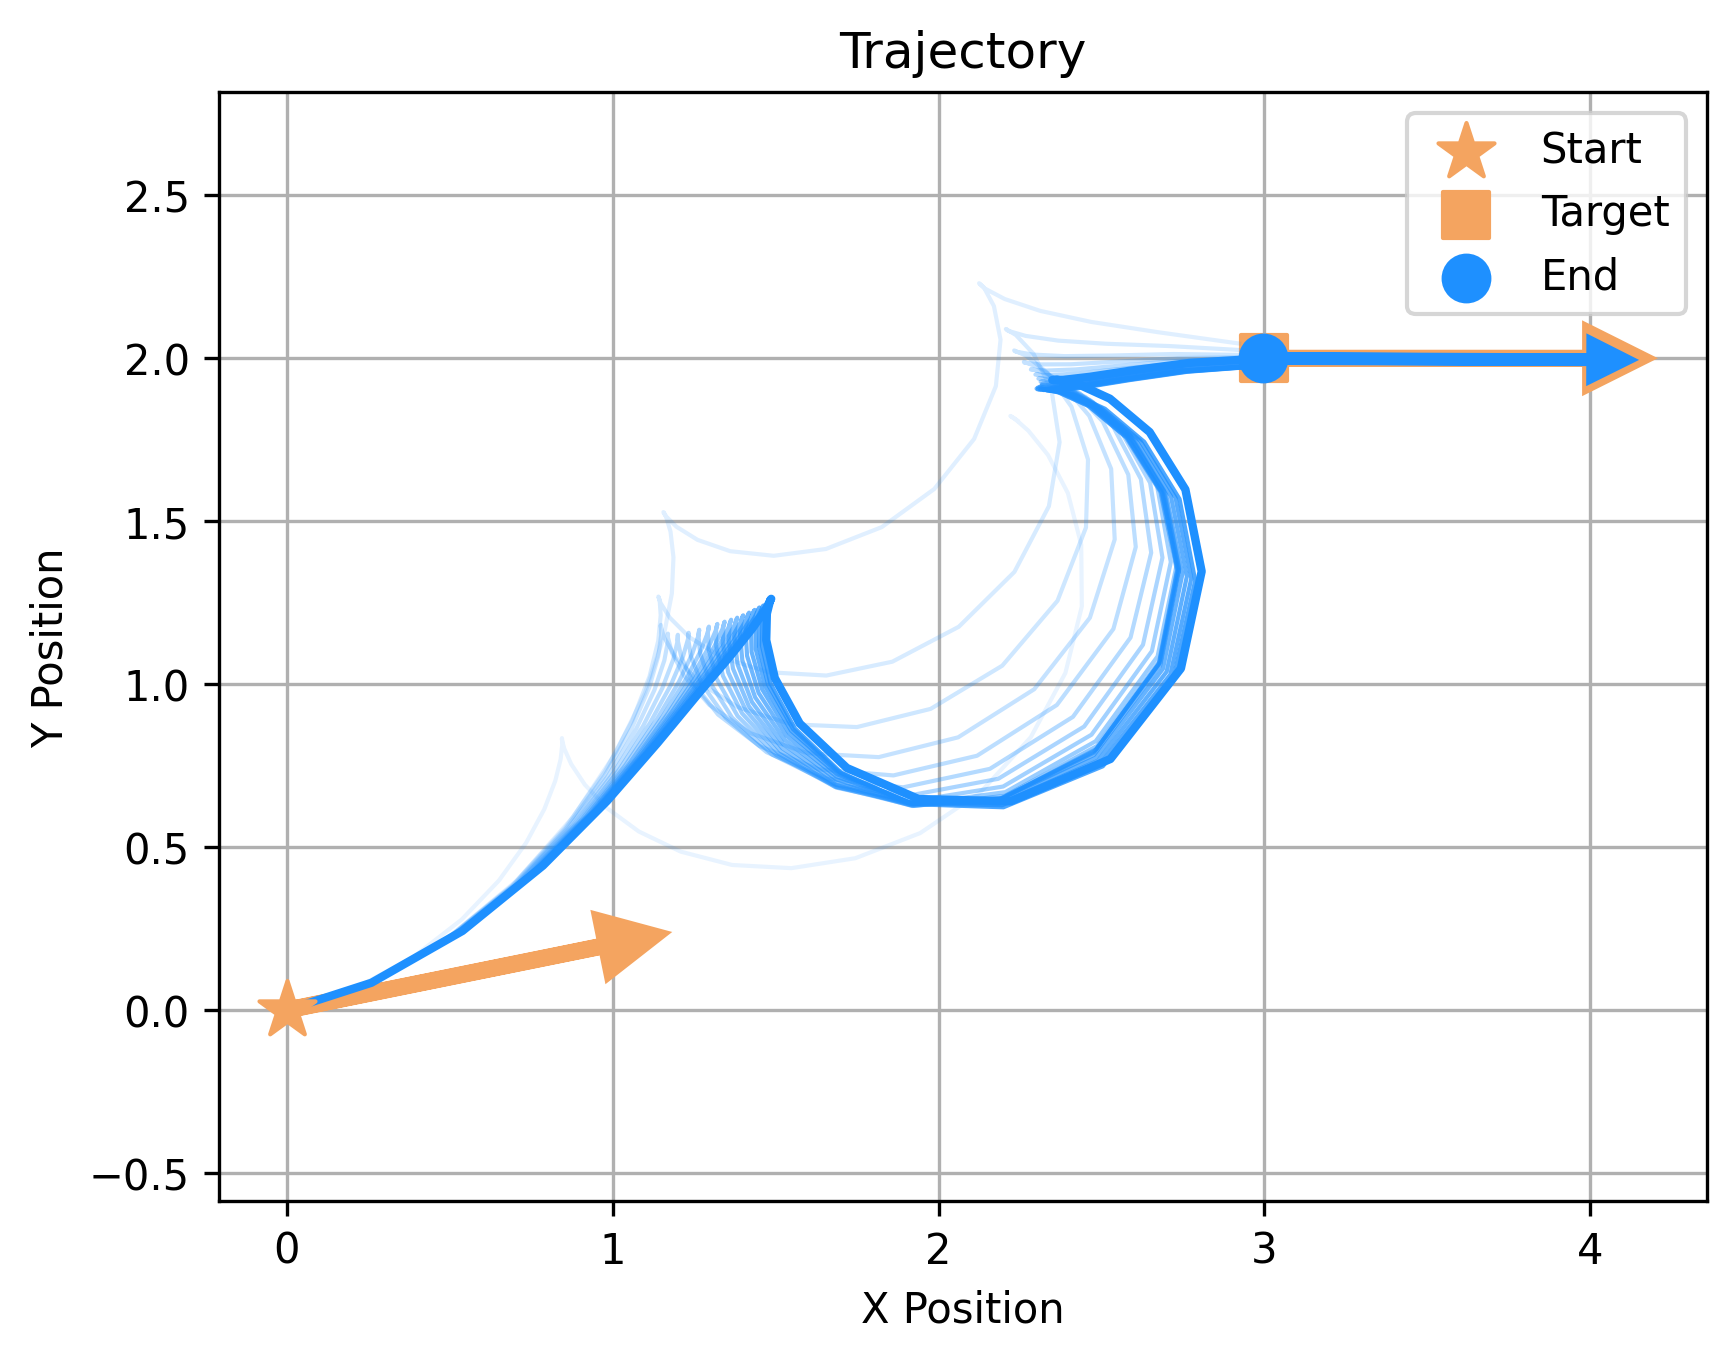

In [8]:
fig, ax = plt.subplots(dpi=300)
plot_traj(V_mat, target, ax=ax)

Path has 32 steps
Iteration 50, Target Dist: 1.109, End Time: 6.274, L2: 0.227
Iteration 100, Target Dist: 0.551, End Time: 6.867, L2: 0.291
Iteration 150, Target Dist: 0.215, End Time: 6.810, L2: 0.293
Iteration 200, Target Dist: 0.107, End Time: 6.763, L2: 0.305
Iteration 250, Target Dist: 0.071, End Time: 6.687, L2: 0.320
Iteration 300, Target Dist: 0.054, End Time: 6.616, L2: 0.338
Iteration 350, Target Dist: 0.046, End Time: 6.553, L2: 0.359
Iteration 400, Target Dist: 0.044, End Time: 6.499, L2: 0.380
Iteration 450, Target Dist: 0.042, End Time: 6.454, L2: 0.401
Iteration 500, Target Dist: 0.040, End Time: 6.418, L2: 0.423
Iteration 550, Target Dist: 0.037, End Time: 6.390, L2: 0.444
Iteration 600, Target Dist: 0.035, End Time: 6.369, L2: 0.465
Iteration 650, Target Dist: 0.034, End Time: 6.353, L2: 0.485
Iteration 700, Target Dist: 0.032, End Time: 6.339, L2: 0.503
Iteration 750, Target Dist: 0.030, End Time: 6.326, L2: 0.519
Iteration 800, Target Dist: 0.030, End Time: 6.316, L

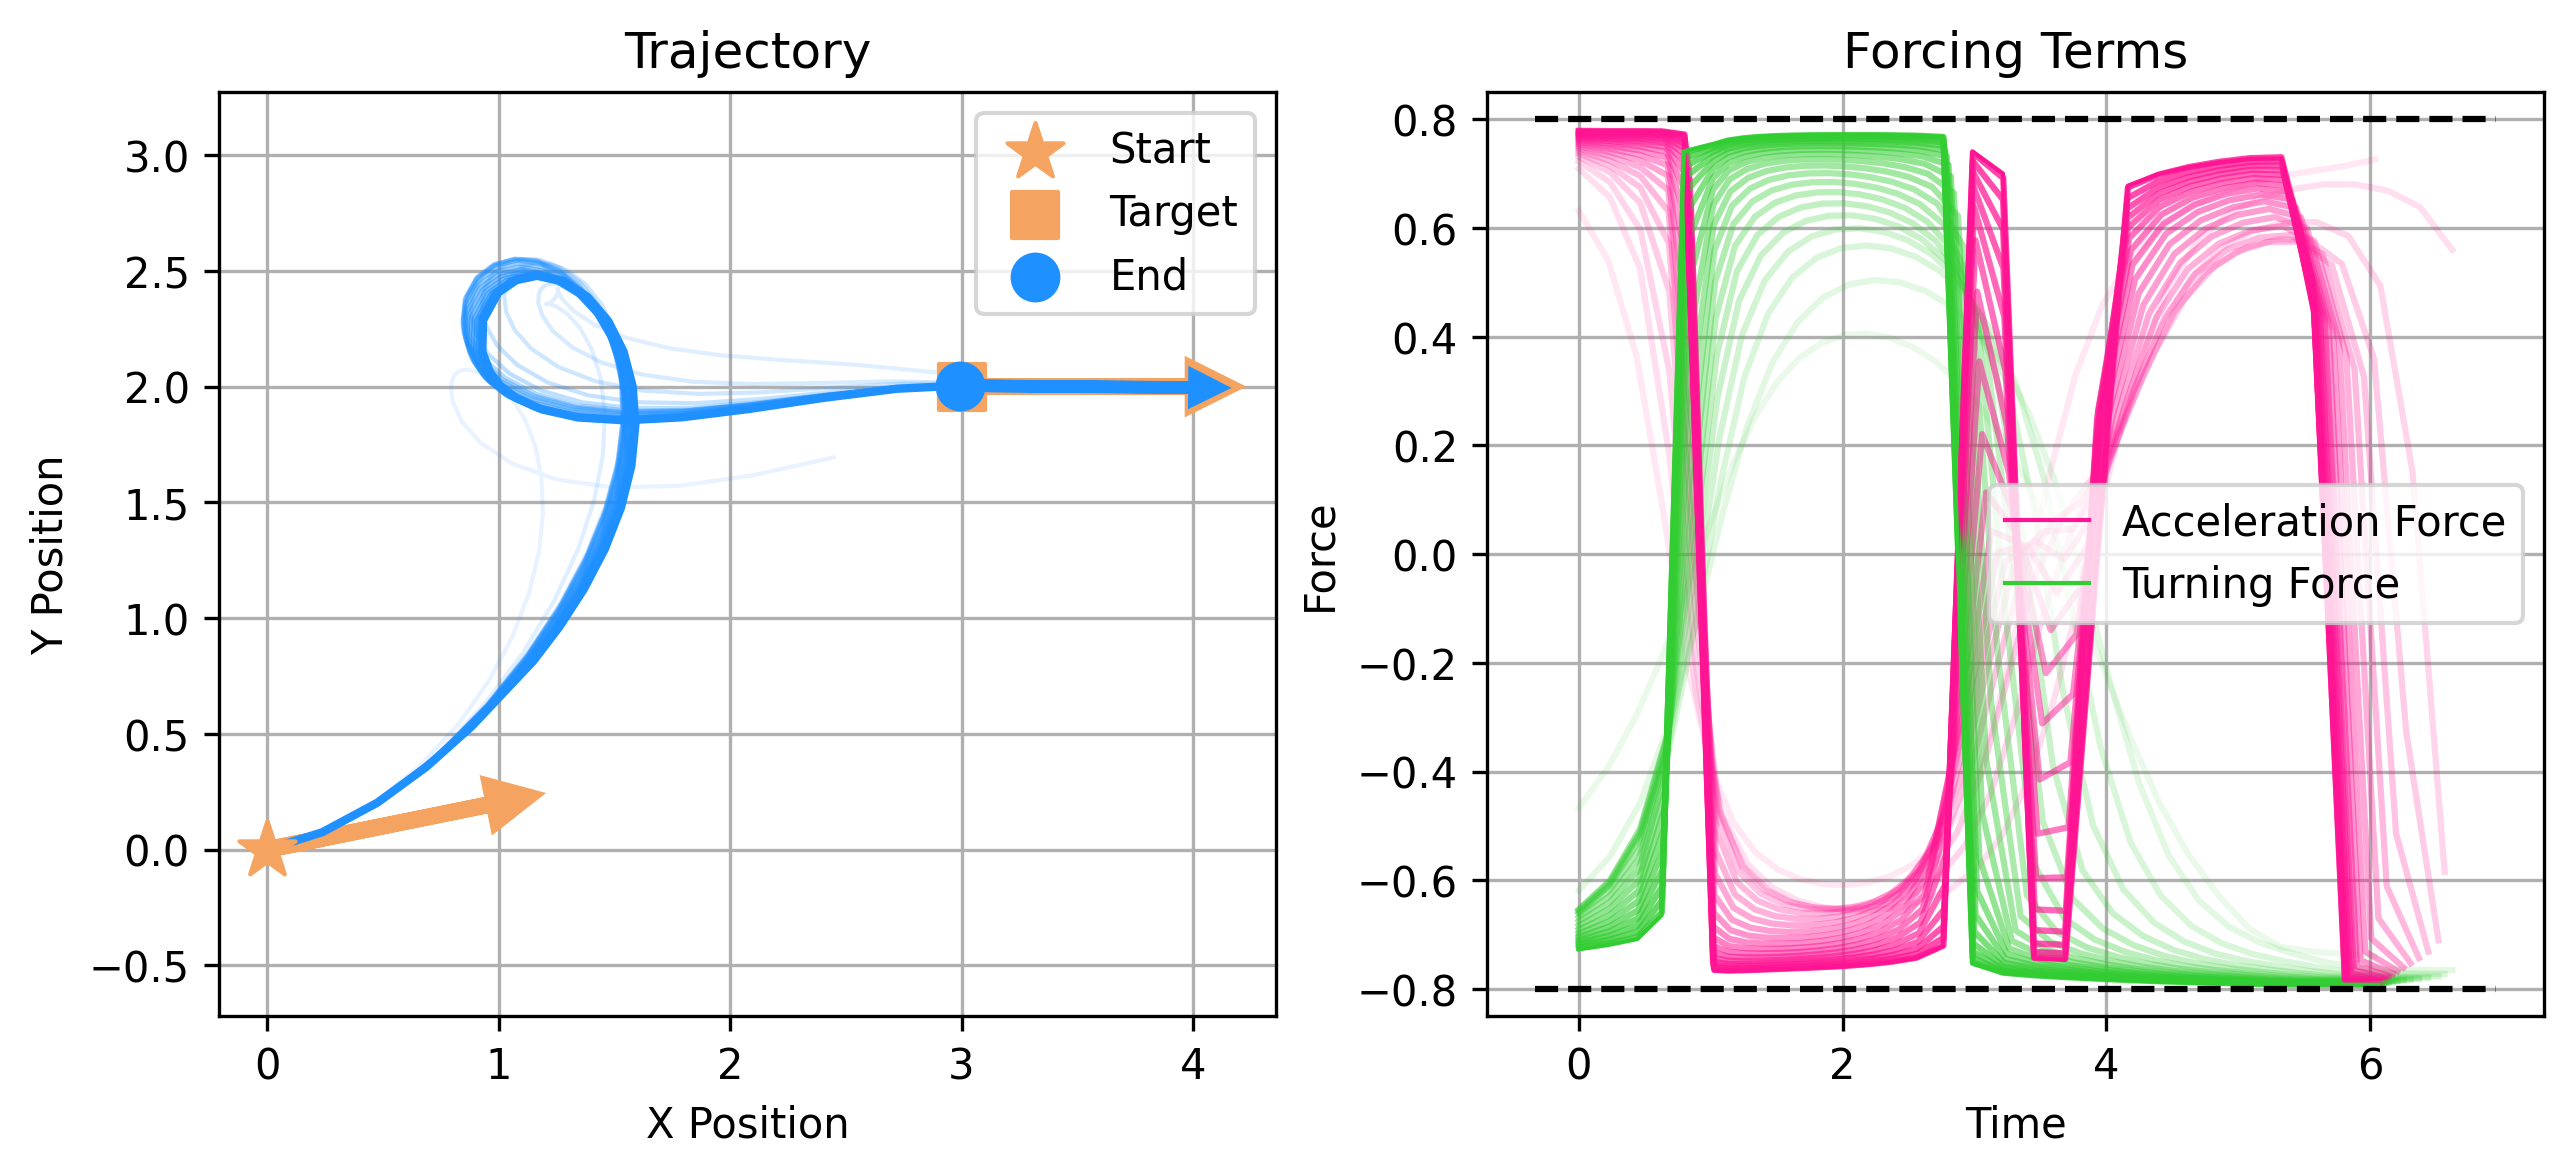

In [9]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = 32

print(f'Path has {n_steps} steps')

F_logits = nn.Parameter(pt.zeros((n_steps, 3)))

F_logits, F_true, V_mat, ts_records, loss_logs = optimizePath(v0, target, F_logits, iters=1000)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_true, ts_records, ax=ax2)
plt.show()

<Axes: title={'center': 'Trajectory'}, xlabel='X Position', ylabel='Y Position'>

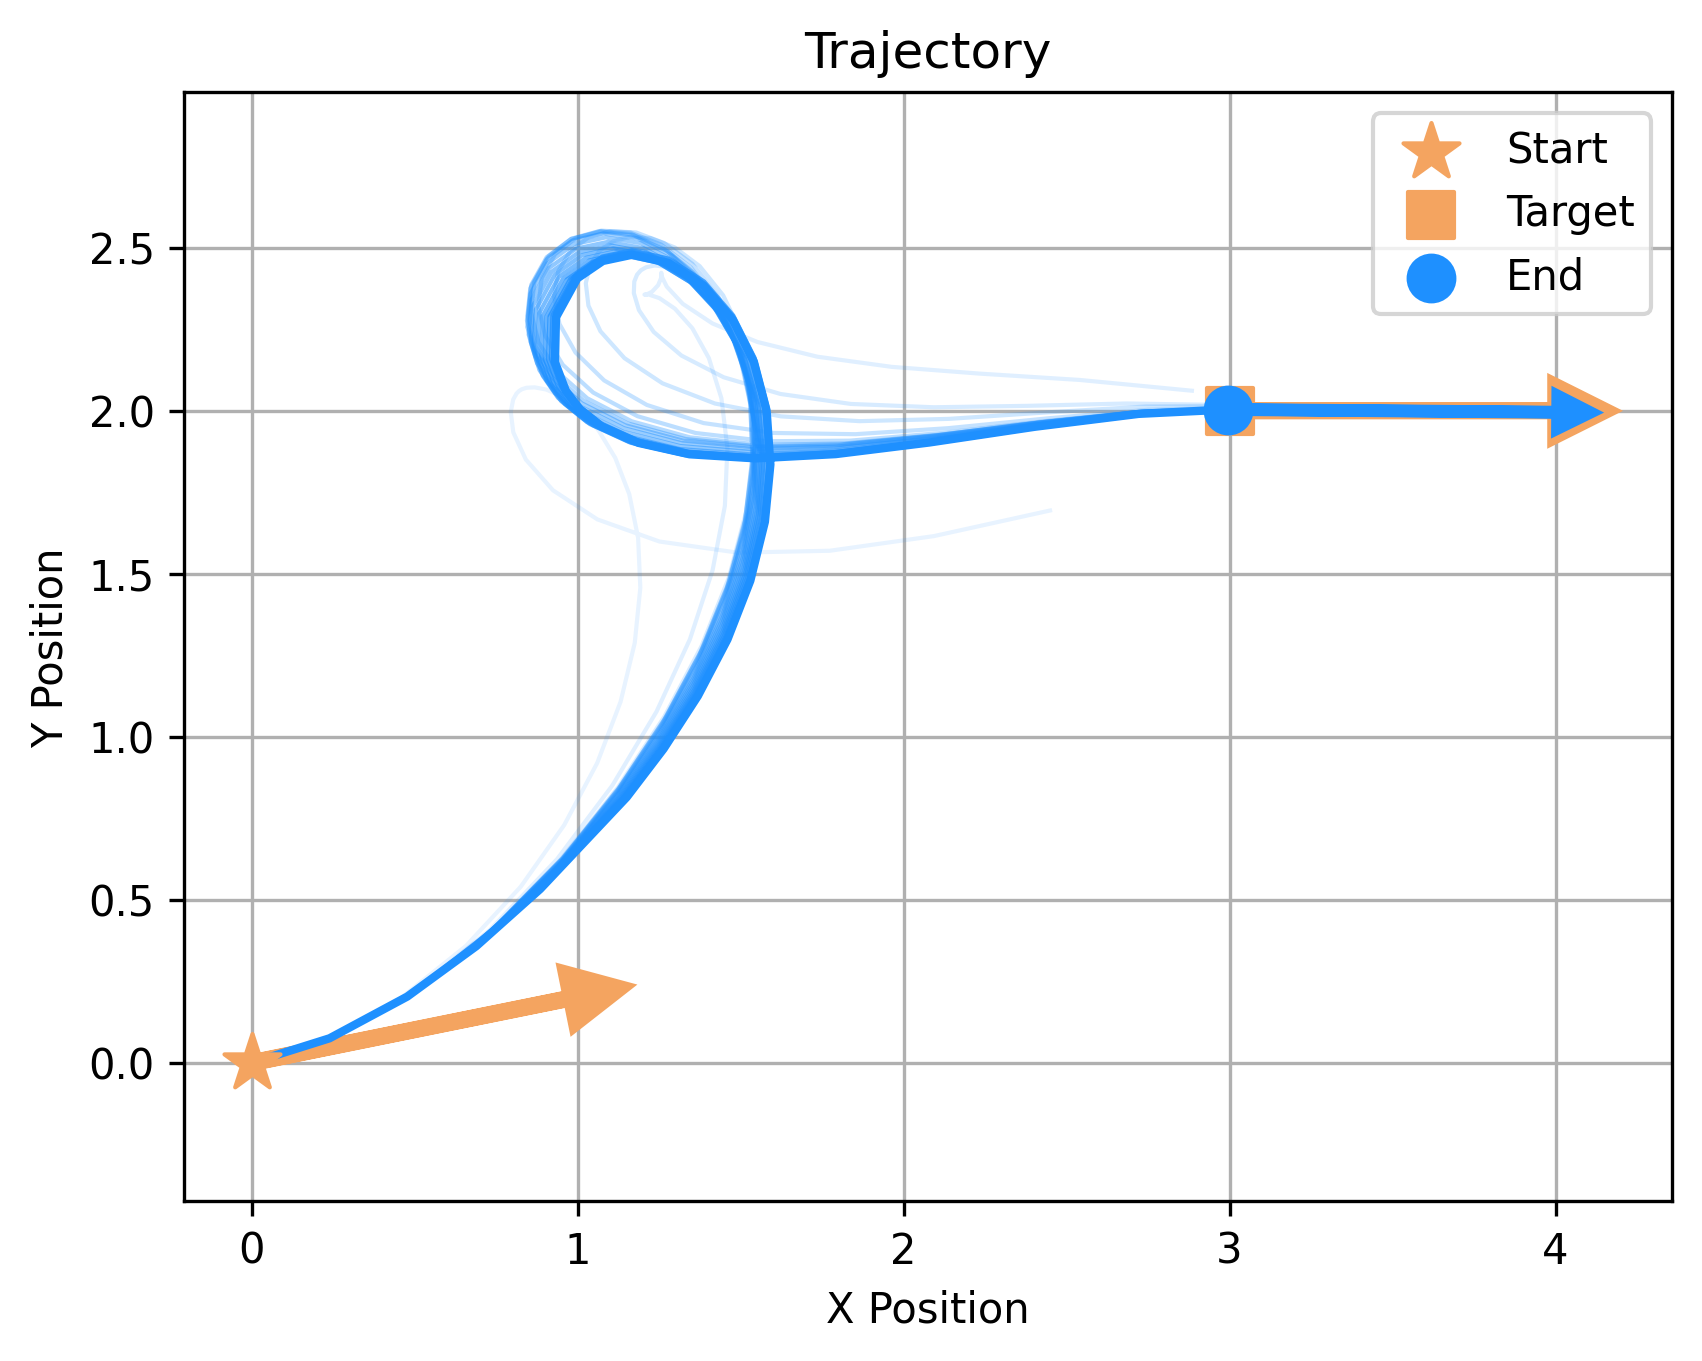

In [10]:
fig, ax = plt.subplots(dpi=300)
plot_traj(V_mat, target, ax=ax)